In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
        
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte   = build_dataset(words[n2:]) # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [125]:
#MLP Revisited (Magic numbers removed for varaibles)
n_embd = 10 # the dimensionaltiy of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) *  (5/3) / (n_embd * block_size)**0.5 # squash thh weights with kaiming equation (see below plots)

# No longer need the bias since it's subtrected out by the mean with batch normlization 
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # Helps create smaller varitions and induce entropy in the biases

W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # Makes w2 elements very small at initilization
b2 = torch.randn(vocab_size,                        generator=g) * 0 # b2's will be 0 at initialization

# Used to scale and shift our batch normzliation during the training runs
# Allows the network to influence the bngain and bnbias during backward prop
# Because of this, they must be added to the parameters array below
bngain = torch.ones((1, n_hidden))#initializes to 1
bnbias = torch.zeros((1, n_hidden)) #initializs to 0

# Used to keep track of or running mean and std across the entire dataset instead of just the batch size
# This allows us to not have to track it afte training, but can do it along side of it
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [126]:
# Now lets work on getting our hpreact neuron activations gaussioned (normal distribution) for our batch size
hpreact.shape

torch.Size([32, 200])

In [127]:
# Lets see the shape of our hidden layer pre activations mean
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [128]:
# Our std shape of the pre activations are aligned so we can perform operations on them
# So we can now solve this below with the formula from the Batch Normlization paper
# This will make it so every batch we take in, we can noramlize them for the next forward pass & backward pass
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [129]:
# same optimzation as last time (Magic Numbers removed for variables)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Our minibatch sample for speed of iteration over our 80% dataset
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # Forward Pass
    emb = C[Xb] # embed the characters in to vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 #+ b1 (no need for bias) # hidden layer pre-activiation before gaussian
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch Gaussian Normaliziation bias

    # This will be updated on the side of our training, and will not be affected by backward prop/gradient decent
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # Hidden Layer
    logits = h @ W2 + b2 # (32, 27) # Output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # Loss function (softmax)
    
    # Backward Pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    #Update the parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
        

      0 /  200000: 3.3111
  10000 /  200000: 2.5342
  20000 /  200000: 1.9578
  30000 /  200000: 2.4050
  40000 /  200000: 2.1535
  50000 /  200000: 2.1007
  60000 /  200000: 1.8789
  70000 /  200000: 1.9506
  80000 /  200000: 2.4958
  90000 /  200000: 2.2811
 100000 /  200000: 2.0015
 110000 /  200000: 2.0569
 120000 /  200000: 1.8678
 130000 /  200000: 2.1272
 140000 /  200000: 1.5888
 150000 /  200000: 1.8355
 160000 /  200000: 2.2442
 170000 /  200000: 2.3872
 180000 /  200000: 2.3752
 190000 /  200000: 2.2005


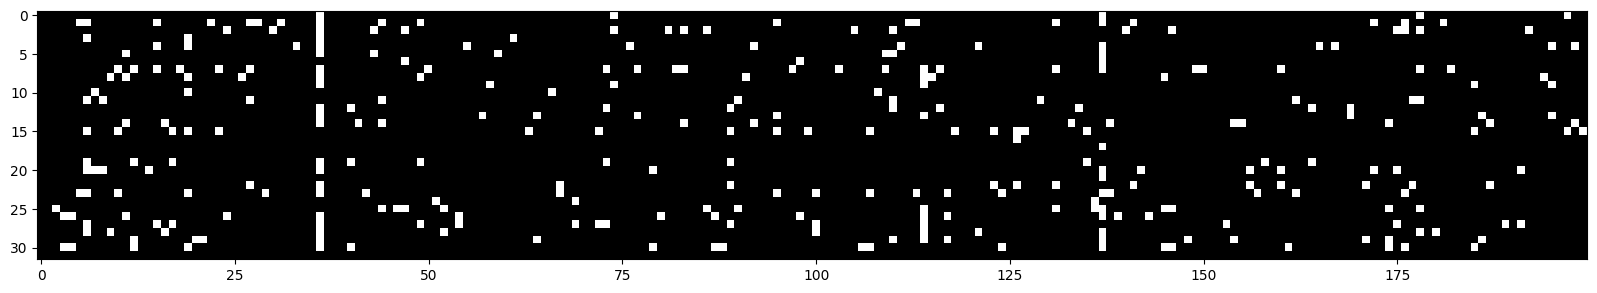

In [130]:
# Can see below that all neurons mostly black (turned on), which means they are firing correclty
# This leaves no chance that their will be "dead neurons" during first activation
# This is due to the fixes we made in our inilzation of weights and biases / batch normlization
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([2567.,  184.,  141.,  118.,  113.,   76.,  122.,  135.,  222.,
        2722.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

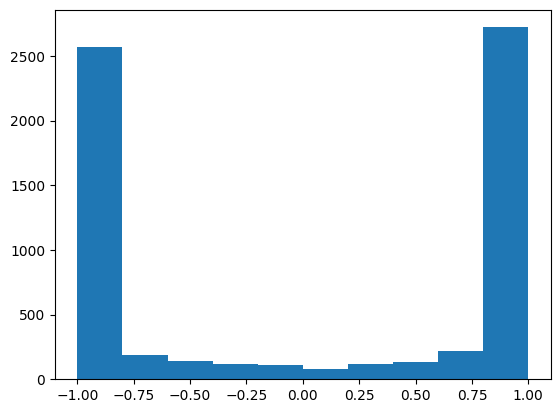

In [46]:
# Can see below that the h nuerons gradients are satured with too many values in the tails of tanh (-1, 1)
# This is why we needed the kaiming init fix seen above
plt.hist(h.view(-1).tolist(), 50)

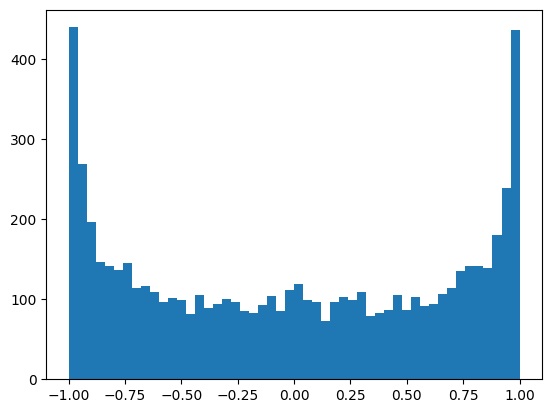

In [131]:
# After fixing the weights & bias preinitzation to squash them closer to 0 using kaiming
# See comments in initilization to observe how we squashed them
plt.hist(h.view(-1).tolist(), 50);

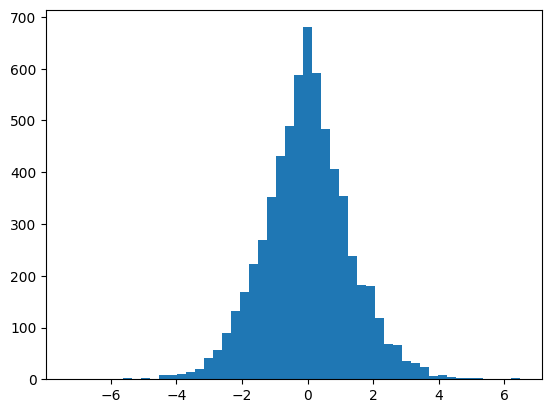

In [132]:
# Our h neurons preactivations now activations much closer to 0 than -20 and 20 like before squashing weights & biases
plt.hist(hpreact.view(-1).tolist(), 50);

In [133]:
# Getting an idea of what our initial loss should be at start
# Given that any 1 of the 27 characters could start, we should have a much more uniform distrubtion of probabilities
# This is reflected below with the negative loss likelihood
# See the fix in the initizliation 
-torch.tensor(1/27.0).log()

tensor(3.2958)

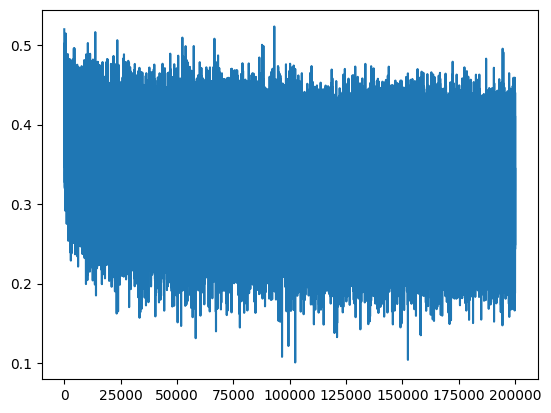

In [134]:
plt.plot(lossi)

In [137]:
@torch.no_grad() #this decorator disables graidnet tracking (Esentially sets require_grad to false for these tensors for efficiency)

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val'  : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # conact into (N, block_size * n_embd)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0648467540740967
val 2.127988815307617


In [ ]:
# Tracking our Loss Logs
# The deeper (more layers) of your network, the less forgiving and harder it is to optimize

# Initial Run
train 2.124558213432
val   2.168490840920

# fix softmax by squashing W2 and b2
train 2.06
val   2.14

# fix tanh layer (too satured with high values at init) by squashing W1 and b1 with kaiming
train 2.03
val   2.11

#  add a batch and norm layer
train 2.06
val 2.12

In [136]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, dimension)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the disribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window to the right and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break out of the loop (end of word)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

catpa.
fatwyn.
vifksmruththtyksstansleja.
bubrddyssahthrrquightkthritziriivanglmilsh.
blavord.
quinthshlilla.
viviquiszefrudharuxikkimburhssabbertgy.
gabbigglutafrashpas.
burthksyahnaqiovohtan.
bjstorias.
genekz.
sadlucofgorgstynveghubnce.
quilmanryah.
bellexqhels.
bbdayadze.
tatswavivllidrnyctislaykerlth.
fzuswnndrett.
blskaythzambreck.
kypadylanorgubrkobberushfrrlyssalyszes.
buxell.


tensor(-0.0109) tensor(1.0051)
tensor(-0.0018) tensor(0.9517)


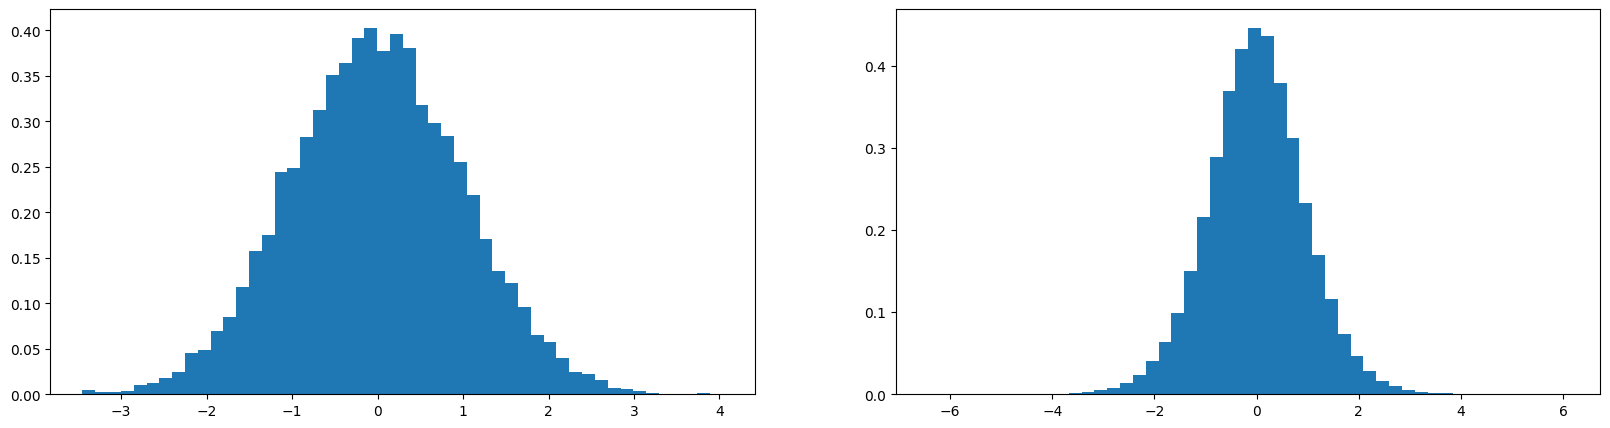

In [74]:
#--------------------- Proper way to calculate the initizliation scale for weights & biases --------------------------

x = torch.randn(1000, 10) #1000 input examples, 10 dimensions(rows))
w = torch.randn(10, 200) # 10 inputs, 200 neurons for each of the 10 inputs
y = x @ w / 10**0.5 # divide by square root of the number of dimensions/inputs (aka the fan-in) -- **0.5 is the same as square root (remember pre-alg :D )
print (x.mean(), x.std())
print (y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# We can see below that the std deviations now closely match, so our scales are now correct


In [77]:
(torch.randn(10000) * 0.2).std() # the number you multply ends up being the std of the gaussian

tensor(0.1980)

In [79]:
# When using tanh, we want the gain to be 5/3 / the fan-in (dimensions * input) 
# So the output below which is .3 is what our standard deviations should be
# This is known as the Kaiming Init for weights
# This scales much better than using magic numbers
(5/3) / 30**0.5

0.3042903097250923

In [138]:
# -------------------------------------------------- Cleaner Summary -------------------------------------------------------

In [139]:
#MLP Revisited 
n_embd = 10 # the dimensionaltiy of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) *  (5/3) / (n_embd * block_size)**0.5 # kaiming init (n_embed * bsize = fan-in) (n_hidden = fan-out)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # Makes w2 elements very small at initilization
b2 = torch.randn(vocab_size,                        generator=g) * 0 # b2's will be 0 at initialization

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))#initializes to 1
bnbias = torch.zeros((1, n_hidden)) #initializs to 0
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # Forward Pass
    emb = C[Xb] # embed the characters in to vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    
    #Linear Layer
    hpreact = embcat @ W1 #hidden layer pre-activiation before gaussian

    # BatchNorm Layer
    #--------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #---------------------------------------------------------------------------------------------

    #Non-linearity
    h = torch.tanh(hpreact) # Hidden Layer
    logits = h @ W2 + b2 # (32, 27) # Output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # Loss function (softmax)
    
    # Backward Pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    #Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

In [ ]:
@torch.no_grad() #this decorator disables graidnet tracking (Esentially sets require_grad to false for these tensors for efficiency)

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val'  : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # conact into (N, block_size * n_embd)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [244]:
#----------------------------------------------- Final Summary + PyTorchifying our Code ----------------------------------------------

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 100 # The number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducbility

C = torch.randn((vocab_size, n_embd),           generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),  BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False ), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False),  BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1 # change the gamma for BatchNorm layers
    # layers[-1].weight *= 0.01 (if !batchnorm, we change the weight)
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of total parameters in our network

for p in parameters:
    p.requires_grad = True

47024


In [245]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # Forward Pass
    emb = C[Xb] # embed the characters in to vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # Backward Pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None 
    loss.backward()

    #Update the parameters
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break # AFTER_DEBUG: would take out obv to run the full optimization

      0 /  200000: 3.3136


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.69%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.53%
layer 8 (      Tanh): mean -0.01, std 0.63, saturated: 2.94%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 2.41%


Text(0.5, 1.0, 'Activation Distribution')

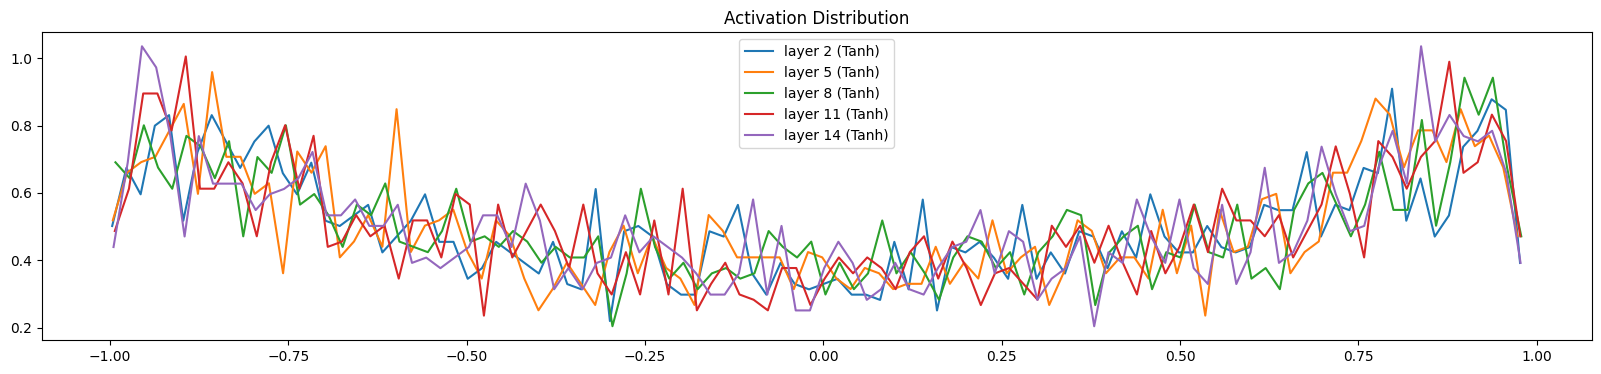

In [246]:
# visualize historgrams
# Forward pass acivations
plt.figure(figsize=(20, 4)) # width and height of hte plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Activation Distribution')


layer 2 (      Tanh): mean +0.000000, std 3.737435e-03
layer 5 (      Tanh): mean +0.000000, std 3.409040e-03
layer 8 (      Tanh): mean +0.000000, std 3.021179e-03
layer 11 (      Tanh): mean -0.000000, std 2.680766e-03
layer 14 (      Tanh): mean +0.000000, std 2.506872e-03


Text(0.5, 1.0, 'Gradient Distribution')

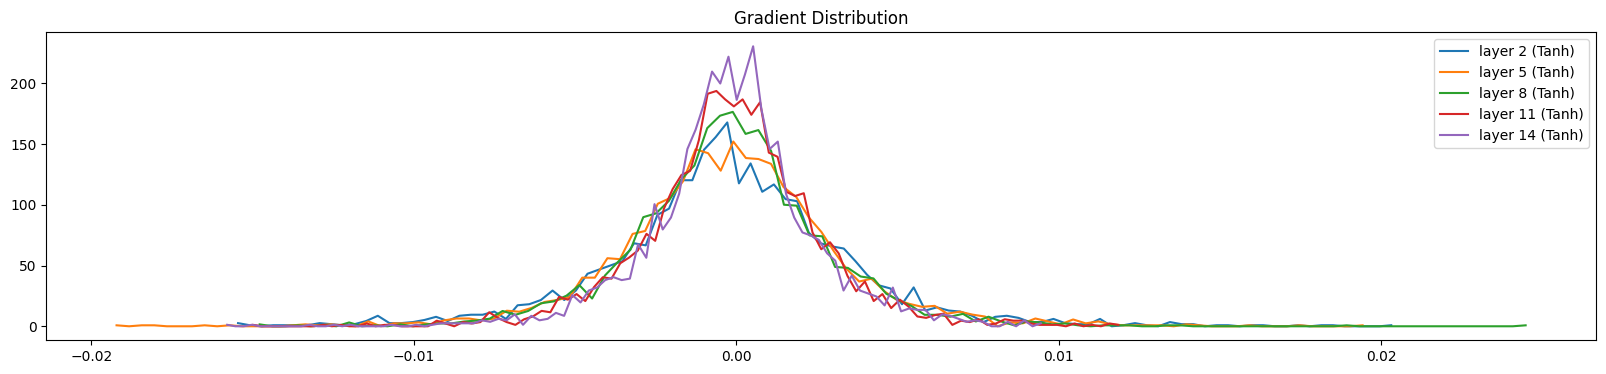

In [247]:
# Gradient Distrubution Histogram
# Backward pass
plt.figure(figsize=(20, 4)) # width and height of hte plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Gradient Distribution')

weight   (27, 10) | mean -0.000000 | std 8.297187e-03 | grad:data ratio 8.289492e-03
weight  (30, 100) | mean +0.000005 | std 2.928851e-03 | grad:data ratio 3.130452e-03
weight (100, 100) | mean +0.000041 | std 2.879719e-03 | grad:data ratio 5.777943e-03
weight (100, 100) | mean -0.000002 | std 2.541655e-03 | grad:data ratio 5.046175e-03
weight (100, 100) | mean +0.000006 | std 2.291783e-03 | grad:data ratio 4.569221e-03
weight (100, 100) | mean -0.000040 | std 2.158677e-03 | grad:data ratio 4.299735e-03
weight  (100, 27) | mean -0.000020 | std 3.766014e-03 | grad:data ratio 7.617285e-03


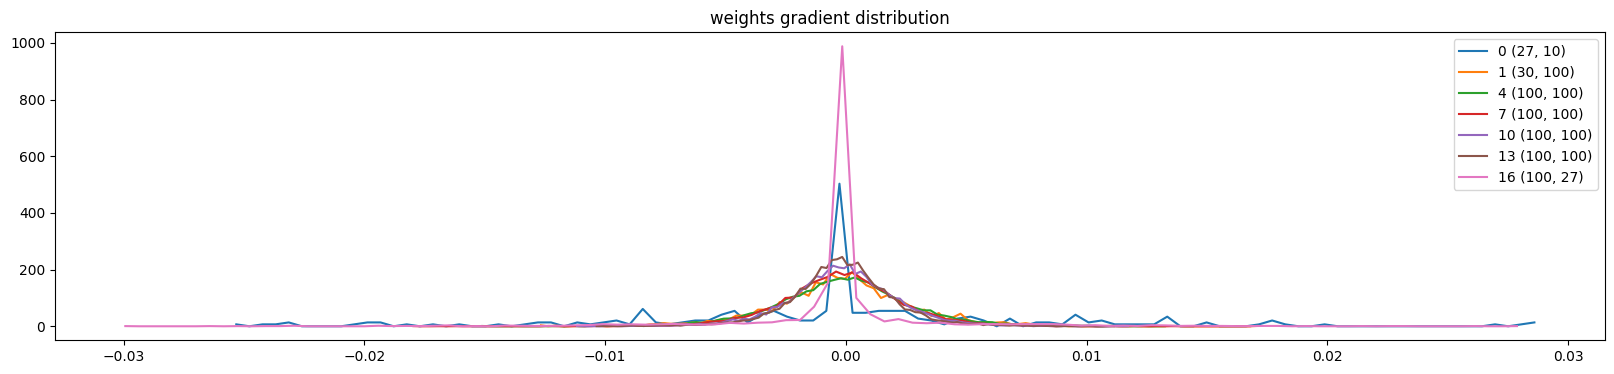

In [248]:
# Weights' Gradient Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

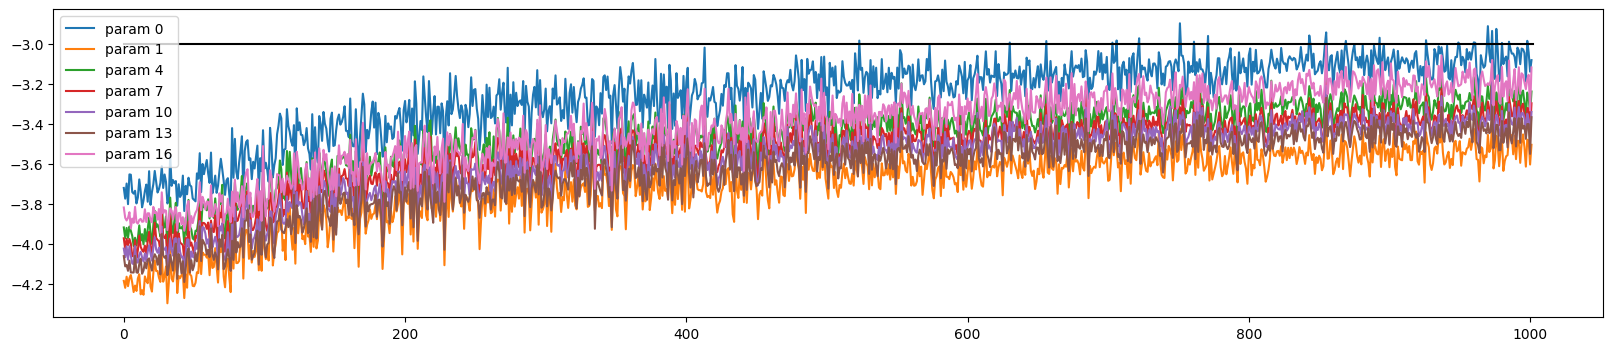

In [249]:
# Update / Data ratio over time
# This graph basically lets us know  that a layers learning rate is training at the proper rate, not too slow, not to fast.
# You want to be just below the black line of -3.0 
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# The reason the final layer (pink) is an outlier is because it's essentially shrunk down to keep the softmax unconfident